In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble  import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention that missings values = -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'<10':0, '10<20': 1, '20<50':2, '50<100':3, '100<500':4, '500<1000':5, '1000<5000':6, '>5000':7}).astype(np.int16)


# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# ACP

In [9]:
numerical_features=list()
for x in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] : 
    numerical_features.append(all_data.columns.get_loc(x))

def run_pca(data, _ncomponents, scaler, nf):
    imputer = Imputer(strategy='mean', missing_values=-1)
    imputer.fit(data)
    X_train_imputed = imputer.transform(data)

    X_train_transformed = X_train_imputed
    X_train_transformed[:,nf] = scaler.fit_transform(X_train_imputed[:,nf])

    pca = PCA(n_components=_ncomponents)
    principalComponents = pca.fit_transform(X_train_transformed)
    
    return principalComponents

def run_kernel_pca(data, scaler, nf, kernel):

    imputer = Imputer(strategy='mean', missing_values=-1)
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)

    X_train_transformed = X_train_imputed
    X_train_transformed[:,nf] = scaler.fit_transform(X_train_imputed[:,nf])
    print(X_train_transformed.shape)
    pca = KernelPCA(n_components=3, kernel=kernel)
    principalComponents = pca.fit_transform(X_train_transformed)
               
    return principalComponents

def plot_pca(data):
    dataPCA = pd.DataFrame(data = data[:,0:2], columns = ['component1', 'component2'])
    dataPCA['CLAIM_TYPE']= target_vectoriser(y_train)

    ax = plt.figure(figsize = (11,11)).add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 12)
    ax.set_ylabel('Principal Component 2', fontsize = 12)

    for target in claim_order:
        rows_claim = dataPCA['CLAIM_TYPE'] == target
        ax.scatter(dataPCA.loc[rows_claim, 'component1'], dataPCA.loc[rows_claim, 'component2'])

    ax.legend(claim_order)
    ax.grid()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.99, random_state=0, stratify=target_number)
print(X_train.shape)    

(638, 295)


In [11]:
%%time
linearPCA = run_pca(X_train, 2, StandardScaler(), numerical_features)

Wall time: 348 ms


In [12]:
%%time
kernelLinear = run_kernel_pca(X_train, StandardScaler(), numerical_features, 'linear')

(638, 295)
Wall time: 247 ms


In [13]:
%%time
kernelRbf = run_kernel_pca(X_train, StandardScaler(), numerical_features, 'rbf')

(638, 295)
Wall time: 191 ms


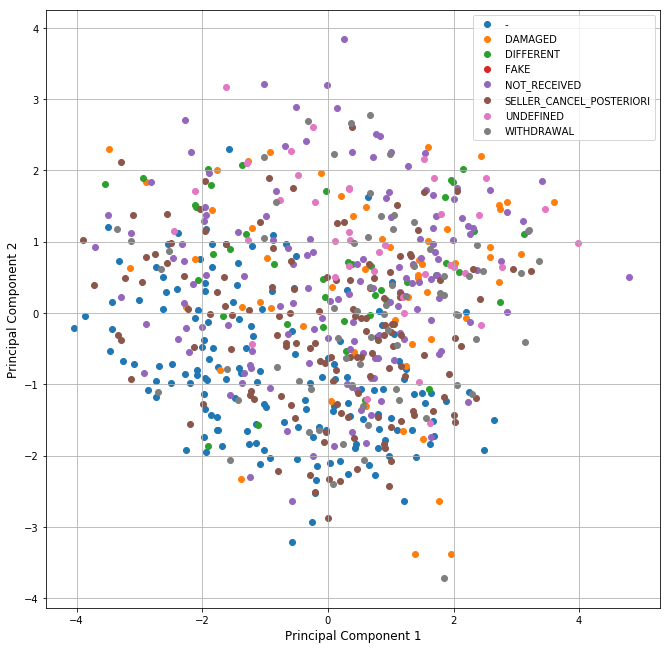

In [14]:
plot_pca(linearPCA)

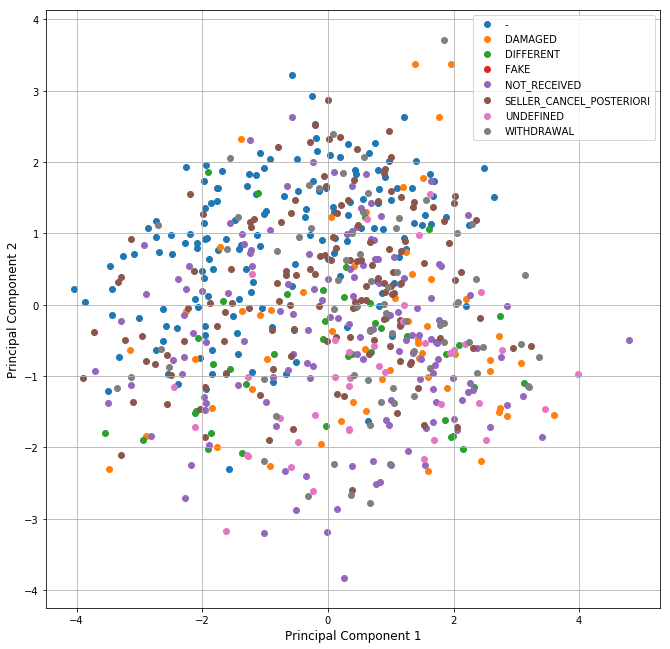

In [15]:
plot_pca(kernelLinear)

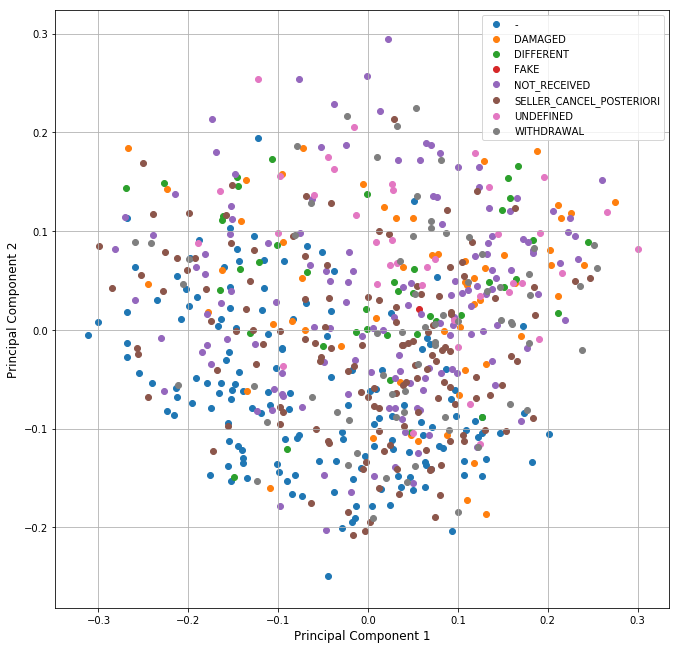

In [16]:
plot_pca(kernelRbf)